In [1]:
#import libraries
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset,DataLoader,random_split
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
from PIL import Image,ImageFile
import torch.optim as optim
import pandas as pd
import copy
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
import cv2
from torchvision import transforms
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from captum.attr import IntegratedGradients
import timm
from torchvision.utils import make_grid
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
import torch.nn.functional as F
from captum.attr import IntegratedGradients



device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

2024-11-28 14:55:20.711456: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-28 14:55:20.728524: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


cuda


In [2]:
seed_val = 420
torch.manual_seed(seed_val)

In [3]:
base_data_dir = '../data/artifact'
fake_dir = os.path.join(base_data_dir, 'generated')  # Fake artworks directory
real_dir = os.path.join(base_data_dir, 'real')  # Real artworks directory

ARTWORK DATASET

In [4]:
#Class to manage artworks with respect to their authenticity

class ArtworkDataset(Dataset):
  def __init__(self,links,transform):
      self.data = links
      self.transform = transform

  def __len__(self):
    return self.data.index.shape[0]
    
  def __getitem__(self,idx):
        img = Image.open(self.data.iloc[idx,0])
        label_index = self.data.iloc[idx, 1]
        if (img.mode != 'RGB'):
            img = img.convert('RGB')

        if self.transform:
          img = self.transform(img)
        return img, label_index


In [5]:
# Create a CSV file with paths to artwork images and their labels (real or fake)
data = [] 

# Iterate over the fake artworks and add their paths and labels to the list
for dirpath, dirnames, filenames in os.walk(fake_dir):
    for filename in filenames:
        if filename.endswith(".jpg"): # only consider jpg files
            filepath = os.path.join(dirpath, filename)
            data.append((filepath, "0"))


# Iterate over the real artworks and add their paths and labels to the list
for dirpath, dirnames, filenames in os.walk(real_dir):
    for filename in filenames:
        if filename.endswith(".jpg"):
            filepath = os.path.join(dirpath, filename)
            data.append((filepath, "1"))  # Label 1 for real artworks

# Convert the list "data" to a pandas dataframe
df = pd.DataFrame(data, columns=["path", "label"])

# Save the dataframe to a CSV file
csv_output_path = os.path.join(base_data_dir, "image_labels.csv")
df.to_csv(csv_output_path, index=False)
print(f"CSV file saved at {csv_output_path}")


CSV file saved at ../data/artifact/image_labels.csv


LOAD PRETRAINED MODEL

In [6]:
model = timm.create_model('convnext_base',pretrained=True, num_classes=2)

model = model.to(device)
print(model)

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (fc2): Linear(in_features=512, out_features=128, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elemen

In [7]:
#Setting the model weights to non-trainable
for param in model.parameters(): 
    param.requires_grad = False

In [8]:
#Make the last layer of the model trainable
for p in model.head.parameters(): #instead of fc, we use head
    p.requires_grad=True


SPLIT IN TRAINING AND VALIDATION SET

In [9]:
dataset = df
dataset['label'] = dataset['label'].astype(int)
dataset

,path,label
0,../data/artifact/generated/stylegan3-t-metface...,0
1,../data/artifact/generated/stylegan3-t-metface...,0
2,../data/artifact/generated/stylegan3-t-metface...,0
3,../data/artifact/generated/stylegan3-t-metface...,0
4,../data/artifact/generated/stylegan3-t-metface...,0
...,...,...
88146,../data/artifact/real/paul-albert-besnard_robe...,1
88147,../data/artifact/real/nikolai-ge_christ-and-th...,1
88148,../data/artifact/real/paul-bril_view-of-a-port...,1
88149,../data/artifact/real/felix-vallotton_the-port...,1


In [10]:
#train, validation = train_test_split(dataset.values, stratify=dataset.values[:, 1], test_size=.3, random_state = 1) 

# Split the dataset into two parts (train + validation, and test)
train_val_data, test = train_test_split(dataset.values, test_size=0.1, random_state=seed_val)

# Split the train + validation part into training and validation sets
train, validation = train_test_split(train_val_data, test_size=0.1, random_state=seed_val)

In [11]:
print(f"Test set size: {len(test)}")

Test set size: 8816


In [12]:
train_links = pd.DataFrame(train, columns = dataset.columns)
validation_links = pd.DataFrame(validation, columns = dataset.columns)
test_links = pd.DataFrame(test, columns = dataset.columns)

In [13]:
train_links[:5]

,path,label
0,../data/artifact/real/felipe-de-vicente_art-67...,1
1,../data/artifact/generated/stylegan3-r-metface...,0
2,../data/artifact/real/johannes-itten_der-bachs...,1
3,../data/artifact/generated/stylegan3-t-metface...,0
4,../data/artifact/real/stanley-spencer_kit-insp...,1


#### DATA LOADERS

In [14]:
# old
data_transforms = transforms.Compose([
                                transforms.Resize(224),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# new
train_transforms = transforms.Compose([
    transforms.Resize(256),                    # Resize to allow cropping
    transforms.RandomCrop(224),                # Crop to 224x224
    transforms.RandomHorizontalFlip(p=0.5),    # Random horizontal flip -- half of the images are mirrored; prevent the model from learning exact position-based cues.
    transforms.RandomRotation(10),             # Small rotation for variability -- helps the model generalize across minor rotations, as real-world artworks and digital images might not always be perfectly aligned.
    transforms.ColorJitter(brightness=0.1, contrast=0.1), # Minimal brightness/contrast -- A brightness and contrast jitter of ±10% introduces slight lighting variability without drastically changing color tones. This adjustment accounts for small lighting and contrast differences that can naturally occur in photographed or scanned artworks, which could otherwise become confounding factors.
    transforms.ToTensor(),                     # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Standard normalization
])

# Validation/test transformations (no augmentation)
val_test_transforms = transforms.Compose([
    transforms.Resize(224),                    # Resize directly to 224x224
    transforms.CenterCrop(224),                # Center crop to ensure consistency
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image
])

batch_size = 32

train_set = ArtworkDataset(train_links, train_transforms)

validation_set = ArtworkDataset(validation_links, val_test_transforms)

test_set = ArtworkDataset(test_links, val_test_transforms)


train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, 
                               drop_last=False,num_workers=6, pin_memory = True)

validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False, 
                               drop_last=False,num_workers=6, pin_memory = True)

test_loader = DataLoader(test_set,batch_size=batch_size, shuffle = False,
                              drop_last=False,num_workers=6, pin_memory = True)

**Early Stopping**

In [15]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0.001):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.wait = 0
        self.best_loss = None
        self.early_stop = False
                
    def __call__(self, current_loss):
        if self.best_loss is None or (current_loss - self.best_loss) < -self.min_delta:
            self.best_loss = current_loss
            self.wait = 0
        else:
            self.wait += 1
            print(f"INFO: Early stopping counter {self.wait} of {self.patience}")
            if self.wait >= self.patience:
                self.early_stop = True

**Functions for visualisation and logging**

In [16]:
# functions for logging the misclassified images in tensorboard
def denormalize_image(tensor, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    """Denormalizes a tensor image by applying the inverse of the normalization transform."""
    # Reshape mean and std to match the (C, H, W) shape of the tensor
    if tensor.dim() == 4:
        tensor = tensor[0]
    mean = torch.tensor(mean).view(3, 1, 1).to(tensor.device)  # Match device as well
    std = torch.tensor(std).view(3, 1, 1).to(tensor.device)
    denormalized = tensor * std + mean
    denormalized = denormalized.clamp(0, 1) # convert to [H, W, C] for matplotlib visualisation

    return denormalized.permute(1, 2, 0).cpu().detach().numpy()

def add_labels_to_image(image, true_label, pred_label):
    """Add true and predicted labels to the image."""
    # Convert the image to uint8 if it's in float format
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    # Convert from RGB to BGR for OpenCV
    bgr_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Prepare text without brackets
    text = f'True: {int(true_label)}, Pred: {int(pred_label)}'
    cv2.putText(bgr_image, text, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

    # Convert back to RGB before returning
    return cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)


In [17]:
def log_misclassified_images(misclassified_images, misclassified_preds, misclassified_true, epoch, writer):
    print("Logging misclassified images...")
    print(len(misclassified_images))
    labeled_images = []

    for i, img in enumerate(misclassified_images):
        img_np = denormalize_image(img)  # Denormalize the image      

        # Ensure the image is in the right format for TensorBoard
        if img_np.shape[-1] == 1:  # Check if the image is grayscale
            img_np = img_np.squeeze(axis=2)  # Remove the channel dimension if it is 1
        elif img_np.shape[0] == 1:  # If the shape is (1, H, W)
            img_np = img_np.squeeze(axis=0)  # Remove the batch dimension
        img_np = np.clip(img_np, 0, 1)  # Ensure the values are between 0 and 1
        img_np = (img_np * 255).astype(np.uint8)     # Scale to 0-255

        true_label = misclassified_true[i]
        pred_label = misclassified_preds[i]

        labeled_image = add_labels_to_image(img_np, true_label, pred_label)
        # labeled_image = labeled_image.transpose(2, 0, 1)
        labeled_images.append(labeled_image)

    # Log image to TensorBoard
    writer.add_images(
        f'Misclassified_Epoch_{epoch}',
        np.array(labeled_images),
        global_step=epoch,
        dataformats='NHWC'
    )


def log_confusion_matrix(all_labels, all_preds, epoch, log_name, writer):
    """Log confusion matrix to TensorBoard."""
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix using Seaborn
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {log_name}')
    plt.tight_layout()

    # Save to buffer and log
    buf = BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    image = np.array(Image.open(buf))
    writer.add_image(f'Confusion_Matrix/{log_name}', image, global_step=epoch, dataformats='HWC')
    buf.close()
    plt.close()

##### GRADCAM and Integrated Gradients

In [18]:
print(model.stages[-1].blocks[-1])

ConvNeXtBlock(
  (conv_dw): Conv2d(1024, 1024, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=1024)
  (norm): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
  (mlp): Mlp(
    (fc1): Linear(in_features=1024, out_features=4096, bias=True)
    (act): GELU()
    (drop1): Dropout(p=0.0, inplace=False)
    (fc2): Linear(in_features=4096, out_features=1024, bias=True)
    (drop2): Dropout(p=0.0, inplace=False)
  )
  (drop_path): Identity()
)


#### TRAINING AND VALIDATION

In [19]:
def train_one_epoch(model, train_loader, criterion, optimizer, scheduler, device, epoch, log_name, writer):
    model.train()  # Set model to training mode
    running_loss = 0.0
    running_corrects = 0

    # Iterate over training data
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch} Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(inputs)
        outputs = nn.Softmax(dim=1)(outputs)  # Apply softmax for classification
        preds = torch.argmax(outputs, dim = 1)

        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    # Compute loss and accuracy for the epoch
    epoch_loss = running_loss / (len(train_loader) * train_loader.batch_size)
    epoch_acc = running_corrects.double() / (len(train_loader) * train_loader.batch_size)

    # Log statistics
    writer.add_scalar(f'Loss/Train/{log_name}', epoch_loss, epoch)
    writer.add_scalar(f'Accuracy/Train/{log_name}', epoch_acc, epoch)

    # Step the scheduler
    scheduler.step()

    print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
    return epoch_acc, epoch_loss


In [20]:
def overlay_heatmap_on_image(image, heatmap, alpha=0.6):
    """
    Overlay a heatmap on an image.
    
    Args:
        image: The original image tensor (C, H, W).
        heatmap: The heatmap (H, W) to overlay.
        alpha: Transparency factor for the overlay (0 to 1).
        
    Returns:
        The image with the overlaid heatmap.
    """
    # Convert tensor image from (C, H, W) to (H, W, C) and denormalize it

    # Resize the heatmap to match the image size
    heatmap_resized = np.resize(heatmap, (image.shape[0], image.shape[1]))

    # Normalize heatmap to [0, 1]
    heatmap_resized = np.maximum(heatmap_resized, 0)  # Avoid negative values
    heatmap_resized = heatmap_resized / np.max(heatmap_resized) 

    # Apply the heatmap on the image (using alpha blending)
    heatmap_colored = plt.cm.jet(heatmap_resized)[:, :, :3]  # Convert heatmap to RGB
    overlay = image * (1 - alpha) + heatmap_colored * alpha
    overlay = (overlay * 255).astype(np.uint8)
    return overlay

In [21]:
def validate_one_epoch(model, validation_loader, criterion, device, epoch, num_epochs, log_name, writer):
    model.eval()  # Set model to evaluation mode
    
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []
    misclassified_images = []
    misclassified_preds = []
    misclassified_true = []


    def save_activation(module, input, output):
        activations.append(output)

    def save_gradients(module, input, output):
        grads.append(output[0])

    with torch.no_grad():
        for inputs, labels in tqdm(validation_loader, desc=f"Epoch {epoch} Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            outputs = nn.Softmax(dim=1)(outputs)  # Apply softmax for classification
            preds = torch.argmax(outputs, dim = 1)
        
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # Collect all predictions and labels for confusion matrix
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Collect misclassified images
            misclassified = preds != labels.data
            if misclassified.any():
                misclassified_images.extend(inputs[misclassified].cpu())
                misclassified_preds.extend(preds[misclassified].cpu().numpy())
                misclassified_true.extend(labels[misclassified].cpu().numpy())


    # Compute loss and accuracy for the epoch
    epoch_loss = running_loss / (len(validation_loader) * validation_loader.batch_size)
    epoch_acc = running_corrects.double() / (len(validation_loader) * validation_loader.batch_size)

    # Log statistics
    writer.add_scalar(f'Loss/Validation/{log_name}', epoch_loss, epoch)
    writer.add_scalar(f'Accuracy/Validation/{log_name}', epoch_acc, epoch)

    print(f"Validation Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    
    # Confusion Matrix
    log_confusion_matrix(all_labels, all_preds, epoch, log_name, writer)
    
    # Log misclassified images (with confusion matrix info)
    # log_misclassified_images(misclassified_images, misclassified_preds, misclassified_true, epoch, writer)


    torch.cuda.empty_cache()

    return epoch_acc, epoch_loss


In [22]:
def fine_tune(model, train_loader, validation_loader, criterion, optimizer, scheduler, early_stop, num_epochs=100, 
              log_name='run1', device='cuda', writer=None):
    best_model = copy.deepcopy(model)
    best_acc = 0.0
    best_epoch = 0
    stop = False

    for epoch in range(1, num_epochs + 1):
        if stop:
            break
        print(f'Epoch {epoch}/{num_epochs}')
        print('-'*120)

        # Training phase
        train_acc, train_loss = train_one_epoch(model, train_loader, criterion, optimizer, scheduler, device, epoch, log_name, writer)

        # Validation phase
        val_acc, val_loss = validate_one_epoch(model, validation_loader, criterion, device, epoch, num_epochs, log_name, writer)

        # Early stopping
        if val_acc > best_acc:
            best_acc = val_acc
            best_epoch = epoch
            best_model = copy.deepcopy(model)

        early_stop(val_loss)
        stop = early_stop.early_stop

        print('-'*120)

    print(f'Best val Acc: {best_acc:4f}')
    print(f'Best epoch: {best_epoch:03d}')
    
    # Save the best model state when training stops
    model_path = os.path.join('saved_models/convnext_model', 'RealArt_vs_FakeArt_convnext_base.pt')
    # torch.save(best_model.state_dict(), model_path)
    print(f"Model saved to: {model_path}")

    return best_model

In [23]:
import os
model_path = os.path.join('saved_models/convnext_model', 'RealArt_vs_FakeArt_convnext_base.pt')
writer = SummaryWriter("runs/IG")

if not os.path.exists(model_path):
   print("Training a new model...")
   criterion = nn.CrossEntropyLoss()
   optimizer = optim.Adam(model.parameters(), lr=1e-3)
   scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
   early_stop = EarlyStopping(patience = 3, min_delta = 0.001)
   ImageFile.LOAD_TRUNCATED_IMAGES = True

   
   # Train and save the best model
   best_model_head = fine_tune(model, train_loader, validation_loader, criterion, optimizer, scheduler, 
                               early_stop, num_epochs = 30, writer = writer)
else: 
     # Model already exists; load it
     print("Loading pre-trained model...")
     model = timm.create_model('convnext_base',pretrained=True, num_classes=2) 
     model.load_state_dict(torch.load(model_path))
     model.to(device)
     print("Model loaded successfully from:", model_path)

Loading pre-trained model...
Model loaded successfully from: saved_models/convnext_model/RealArt_vs_FakeArt_convnext_base.pt


TESTING

In [24]:
print(model.stages[-1].blocks[0])

ConvNeXtBlock(
  (conv_dw): Conv2d(1024, 1024, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=1024)
  (norm): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
  (mlp): Mlp(
    (fc1): Linear(in_features=1024, out_features=4096, bias=True)
    (act): GELU()
    (drop1): Dropout(p=0.0, inplace=False)
    (fc2): Linear(in_features=4096, out_features=1024, bias=True)
    (drop2): Dropout(p=0.0, inplace=False)
  )
  (drop_path): Identity()
)


In [25]:
def denormalize_image_xai(tensor, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    """Denormalizes a tensor image by applying the inverse of the normalization transform."""
    # Reshape mean and std to match the (C, H, W) shape of the tensor
    mean = torch.tensor(mean).view(3, 1, 1).to(tensor.device)  # Match device as well
    std = torch.tensor(std).view(3, 1, 1).to(tensor.device)
    denormalized = tensor * std + mean
    return denormalized.clamp(0, 1)

In [26]:
def overlay_grad_cam_on_image(original_image, cam_image, alpha=0.5, scale_factor=2):
    """Overlays the Grad-CAM image on the original image with some transparency."""
    # Ensure the original image is in [0, 1] range if it's in [0, 255]
    if original_image.max() > 1:  # This means the image is in [0, 255] range
        original_image = original_image.astype(np.float32) / 255.0  # Normalize to [0, 1]
    
    # Normalize Grad-CAM to [0, 1]
    cam_image = cam_image.astype(np.float32)  # Ensure float32 type
    cam_image = np.clip(cam_image, 0, 1)  # Clip to make sure it's within [0, 1]

    # Apply a scaling factor to the Grad-CAM image
    cam_image = cam_image * scale_factor
    cam_image = np.clip(cam_image, 0, 1)  # Make sure the scaled cam_image stays within [0, 1]

    # Apply a colormap to the Grad-CAM image to get the heatmap effect (rainbow)
    cam_image = plt.get_cmap('jet')(cam_image)  # Apply the 'jet' colormap

    # The colormap adds an extra dimension, we need to remove it
    cam_image = cam_image[..., :3]  # Take the RGB channels (ignore the alpha channel)

    # Apply overlay with transparency (alpha blending)
    overlay = original_image * (1 - alpha) + cam_image * alpha
    overlay = np.clip(overlay, 0, 1)  # Ensure values are valid for display

    # Convert to uint8 for visualization
    overlay_uint8 = (overlay * 255).astype(np.uint8)
    
    return overlay_uint8

def apply_grad_cam(model, images, preds, true_labels, writer):
    """Applies Grad-CAM++ to misclassified images and logs them to TensorBoard."""
    target_layers = [model.stages[-1].blocks[-1].conv_dw]  # Example target layer
    print("Using target layer:", target_layers)

    cam = GradCAMPlusPlus(model=model, target_layers=target_layers)

    for idx, (image, true, pred) in enumerate(zip(images, true_labels, preds)):
        # Denormalize the image to [0, 1] range
        image = denormalize_image_xai(image, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        image_np = image.numpy().transpose(1, 2, 0)  # Convert tensor to numpy (H, W, C)

        if len(image.shape) == 3:
            image = image.unsqueeze(0)  # Add batch dimension

         # Apply softmax to the logits to get probabilities
        image = image.to(device)
        
        # Generate Grad-CAM visualization
        grayscale_cam = cam(input_tensor=image)

        # Overlay Grad-CAM on the original image with transparency
        overlay_image = overlay_grad_cam_on_image(image_np, grayscale_cam[0], alpha=0.5)

        # Add labels to the image
        overlay_image_with_labels = add_labels_to_image(overlay_image, true, pred)

        fig = plot_grad_cam(image_np, true, pred, overlay_image_with_labels)

        # Log the image with labels to TensorBoard
        overlay_image_tensor = transforms.ToTensor()(overlay_image_with_labels)
        writer.add_image(f"Grad-CAM/True_{true}_Pred_{pred}_{idx}", overlay_image_tensor, global_step=idx)

        fig.canvas.draw()
        plot_tensor = torch.from_numpy(
            np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        ).reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plot_tensor = plot_tensor.permute(2, 0, 1) / 255.0  # Convert to CxHxW and normalize

        # Log the plot to TensorBoard
        writer.add_image(f"Grad-CAM/Testing", plot_tensor)

        plt.close(fig)  # Close the figure to free memory
       

In [27]:
def detect_faces_in_images(images):
    face_cascade = cv2.CascadeClassifier("/home/oem/eliza/DL/project/ai-art-detection/analysis/haarcascade_frontalface_default.xml")
    face_detected_count = 0
    total_images = len(images)

    for image in images:
        # Convert tensor to numpy and denormalize
        image_np = image.numpy().transpose(1, 2, 0)  # Convert (C, H, W) to (H, W, C)
        image_np = (image_np * 255).astype(np.uint8)  # Convert to uint8 format
        
        # Convert to grayscale for Haar Cascade
        gray_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        
        # Detect faces
        faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        if len(faces) > 0:
            face_detected_count += 1

    return face_detected_count, total_images


In [28]:
def log_integrated_gradients(
    model, input_tensor, target_class, writer, step, alpha=0.7, true_label=None, pred_label=None):
    """
    Computes and logs Integrated Gradients (IG) visualizations to TensorBoard.
    """

    # Use CPU for visualization to save GPU memory
    device = input_tensor.device
    model = model.to("cpu")
    input_tensor = input_tensor.to("cpu")

    # Compute Integrated Gradients attributions
    model.eval()
    ig = IntegratedGradients(model)

    # Use a smaller number of steps to reduce memory load
    attributions = ig.attribute(input_tensor, target=target_class, n_steps=50)
    attributions = attributions.squeeze().detach().numpy()  # Shape: (C, H, W)

    # Reduce multi-channel attributions to a single-channel map
    attributions = attributions.mean(axis=0)  # Shape: (H, W)

    # Normalize attributions to range [0, 1]
    attributions = (
        (attributions - attributions.min()) / (attributions.max() - attributions.min() + 1e-8)
    )

    # Prepare the heatmap: Normalize and convert to uint8
    heatmap = (attributions * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)  # Use a high-contrast colormap for better clarity

    # Denormalize the input image tensor (no grayscale handling here)
    image = denormalize_image_xai(input_tensor.squeeze())
    image = image.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format for plotting

    # Ensure image has 3 channels (RGB)
    image = np.clip(image, 0, 1)  # Ensure values are in range [0, 1]
    overlay_image = (image * 255).astype(np.uint8)

    # Create the overlay with IG heatmap
    overlay = cv2.addWeighted(overlay_image, 1 - alpha, heatmap, alpha, 0)

    # Add labels to overlay if provided (true and predicted labels)
    if true_label is not None and pred_label is not None:
        overlay = add_labels_to_image(overlay, true_label, pred_label)

    # Log the original and overlay images to TensorBoard
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(overlay)
    ax[1].set_title("IG Overlay")
    ax[1].axis("off")

    # Use a unique tag for each batch step
    writer.add_figure(f"IG/Testing_Batch_{step}", fig)  # Tagging with the batch step
    plt.close(fig)

    # Return the model to its original device
    model = model.to(device)


In [29]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# testing function
def test_model(model, test_loader):
    model.eval() # evaluation mode
    test_loss = 0
    correct = 0
    pred_list = []
    true_list = []
    misclassified_images = []
    misclassified_preds = []
    misclassified_true = []


    # progress bar
    pbar = tqdm(total=len(test_loader))
    
    with torch.no_grad():
        for step, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sommo il loss di ogni batch
            
            pred = output.argmax(dim=1, keepdim=True) # ottengo la predizione del modello
            pred_list.extend(pred.cpu().numpy()) # aggiungo la predizione alla lista
            true_list.extend(target.cpu().numpy()) # aggiungo il target alla lista
            
            correct += pred.eq(target.view_as(pred)).sum().item() # aggiorno il contatore di classificazioni corrette

            misclassified = ~pred.eq(target.view_as(pred)).squeeze()
            if misclassified.any():
                misclassified_images.extend(data[misclassified].cpu())
                misclassified_preds.extend(pred[misclassified].cpu().numpy())
                misclassified_true.extend(target[misclassified].cpu().numpy())

            # Clear CUDA cache
            torch.cuda.empty_cache()

            # update progress bar
            pbar.update(1)

            
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    recall = recall_score(true_list, pred_list, average='macro')
    precision = precision_score(true_list, pred_list, average='macro') 
    f1 = f1_score(true_list, pred_list, average='macro') 
    auc = roc_auc_score(true_list, pred_list) 
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%), Recall: {:.2f}%, Precision: {:.2f}%, F1: {:.2f}%, AUC: {:.2f}%\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy, recall*100, precision*100, f1*100, auc*100))
    
    
    # log_misclassified_images(misclassified_images, misclassified_preds, misclassified_true, None, writer)
    log_confusion_matrix(true_list, pred_list, 1, "Testing", writer)
    # apply_grad_cam(model, misclassified_images, misclassified_preds, misclassified_true, writer)
    # Select the first image in the batch

    writer.flush()
    return accuracy, recall, precision, f1, auc


use this for logs:
tensorboard --logdir=./runs

In [30]:
# accuracy,recall,precision,f1,auc = test_model(model,test_loader)
writer.close()

In [31]:
def plot_grad_cam(image, true, pred, overlay_image):
    """Plots the original image and Grad-CAM overlay image side by side."""
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the original image
    ax[0].imshow(image)
    ax[0].set_title(f"Original Image\nTrue: {true}, Pred: {pred}")
    ax[0].axis('off')

    # Plot the Grad-CAM overlay image
    ax[1].imshow(overlay_image)
    ax[1].set_title(f"Grad-CAM Overlay last layer\nTrue: {true}, Pred: {pred}")
    ax[1].axis('off')
    return fig

def apply_grad_cam_on_image(model, image_path, target_layer, device, true_label=None):
    """
    Applies Grad-CAM++ on a specific image provided by its file path.

    Args:
        model: Trained model.
        image_path: Path to the image file.
        target_layer: The target layer for Grad-CAM (e.g., a convolutional layer in the model).
        device: Device to perform computations (CPU/GPU).
        true_label: (Optional) True label of the image for reference.

    Returns:
        None
    """
    # Load the image
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Adjust size based on the model's input
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Adjust mean/std as per training
    ])
    input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)  # Get probabilities
        predicted_class_idx = probabilities.argmax(dim=1).item()  # Get the predicted class index
        predicted_prob = probabilities[0, predicted_class_idx].item() * 100  # Probability of the predicted class


    cam = GradCAMPlusPlus(model=model, target_layers=[target_layer])
    grayscale_cam = cam(input_tensor=input_tensor)[0]

    # Convert the image to numpy for visualization
    denormalized_image = denormalize_image_xai(
        input_tensor.squeeze(0), mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
    ).cpu().numpy().transpose(1, 2, 0)

    
    # Overlay Grad-CAM on the original image
    overlay_image = overlay_grad_cam_on_image(denormalized_image, grayscale_cam, alpha=0.5)

    overlay_image_with_labels = add_labels_to_image(overlay_image, true_label, predicted_class_idx)

    # Plot the original and Grad-CAM overlay images
    plot_grad_cam(
        denormalized_image,
        true_label,
        f"Predicted: {predicted_class_idx} ({predicted_prob:.2f}%)",
        overlay_image_with_labels
    )

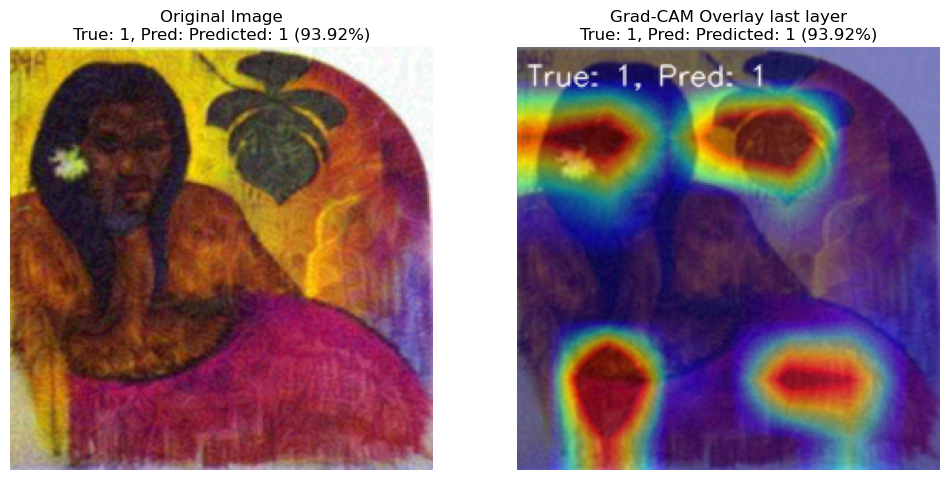

In [32]:
image_path = "/home/oem/eliza/DL/project/data/deepfakeart/generated/adversarial/FGSM/similar-adversarial-3-adv_FGSM.png"
target_layer = model.stages[-1].blocks[-1].conv_dw  # Replace with your model's Grad-CAM target layer
apply_grad_cam_on_image(model, image_path, target_layer, device=device, true_label=1)


In [140]:
import cv2
import numpy as np

def overlay_gradients_on_image(image, attributions, alpha=0.5):
    """
    Overlay the integrated gradients (IG) attribution map on the original image.

    Args:
        image (numpy array): The original image in HWC format (uint8).
        attributions (numpy array): The attribution map (C, H, W).
        alpha (float): The opacity of the attribution overlay.

    Returns:
        numpy array: The image with the overlayed integrated gradients.
    """
    # Ensure attribution map is 2D (H, W) and normalize
    attribution_map = np.squeeze(attributions)  # Remove extra dimensions if any
    if attribution_map.ndim > 2:
        attribution_map = attribution_map.mean(axis=0)  # Optionally, average across channels
    attribution_map = np.clip(attribution_map, 0, 1)  # Normalize to [0, 1]
    attribution_map = np.power(attribution_map, 0.7)  # Gamma correction

    attribution_map = (attribution_map * 255).astype(np.uint8)  # Convert to uint8 for applyColorMap
    

    # Apply a color map to the attribution map
    heatmap = cv2.applyColorMap(attribution_map, cv2.COLORMAP_INFERNO)
    heatmap = cv2.convertScaleAbs(heatmap, alpha=2.0, beta=50)  # Adjust alpha/beta to boost contrast


    # Resize heatmap to match the image size
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    image = (image*255).astype(np.uint8)  # Ensure image is uint8 before blending

    # Blend the heatmap with the original image using alpha blending
    overlay = cv2.addWeighted(image, 1 - alpha, heatmap_resized, alpha, 0)

    return overlay


In [141]:

def plot_integrated_gradients(original_image, true_label, prediction_text, overlay_image):
    """
    Plots the original image, the overlay image with integrated gradients, and prediction text.

    Args:
        original_image (numpy array): The original input image (in HWC format).
        true_label (int): The true label of the image.
        prediction_text (str): The prediction text to display.
        overlay_image (numpy array): The image with the overlay of attributions.

    Returns:
        None
    """
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot the original image
    ax[0].imshow(original_image)
    ax[0].set_title(f"True Label: {true_label}")
    ax[0].axis('off')  # Hide axes

    # Plot the overlay image with integrated gradients
    ax[1].imshow(overlay_image)
    ax[1].set_title(f"{prediction_text}")
    ax[1].axis('off')  # Hide axes

    # Display the plot
    plt.tight_layout()
    plt.show()


In [171]:
# Function to denormalize the image and make sure tensors are on the same device
def denormalize_image(tensor, mean, std, device):
    # Ensure mean and std are on the same device as the input tensor (CUDA or CPU)
    mean_tensor = torch.tensor(mean, device=device).view(-1, 1, 1)
    std_tensor = torch.tensor(std, device=device).view(-1, 1, 1)
    denormalized = tensor * std_tensor + mean_tensor
    return denormalized



# Function to apply Integrated Gradients on the image
def apply_integrated_gradients_on_image(model, image_path, device, true_label=None):
    """
    Applies Integrated Gradients (IG) on a specific image provided by its file path.

    Args:
        model: Trained model.
        image_path: Path to the image file.
        device: Device to perform computations (CPU/GPU).
        true_label: (Optional) True label of the image for reference.

    Returns:
        None
    """
    # Move the model to the correct device (GPU or CPU)
    model.to(device)

    # Load the image
    image = Image.open(image_path).convert("RGB")

    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Adjust size based on the model's input
        transforms.ToTensor(),
       transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Adjust mean/std as per training
    ])
    input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to the selected device

    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)  # Get probabilities
        predicted_class_idx = probabilities.argmax(dim=1).item()  # Get the predicted class index
        predicted_prob = probabilities[0, predicted_class_idx].item() * 100  # Probability of the predicted class

    # Apply Integrated Gradients
    ig = IntegratedGradients(model)
    attributions = ig.attribute(input_tensor, target=predicted_class_idx, n_steps=200, internal_batch_size=1)
    attributions = attributions.squeeze().cpu().numpy()  # Convert to numpy array (C, H, W)

    denormalized_image = denormalize_image_xai(
        input_tensor.squeeze(0), mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
    ).cpu().numpy().transpose(1, 2, 0)

    # Overlay IG attributions on the image
    overlay_image = overlay_gradients_on_image(denormalized_image, attributions, alpha=0.75)

    # Add labels to the image
    overlay_image_with_labels = add_labels_to_image(overlay_image, true_label, predicted_class_idx)

    # Plot the original image and IG overlay image
    plot_integrated_gradients(
        denormalized_image,
        true_label,
        f"Predicted: {predicted_class_idx} ({predicted_prob:.2f}%)",
        overlay_image_with_labels
    )


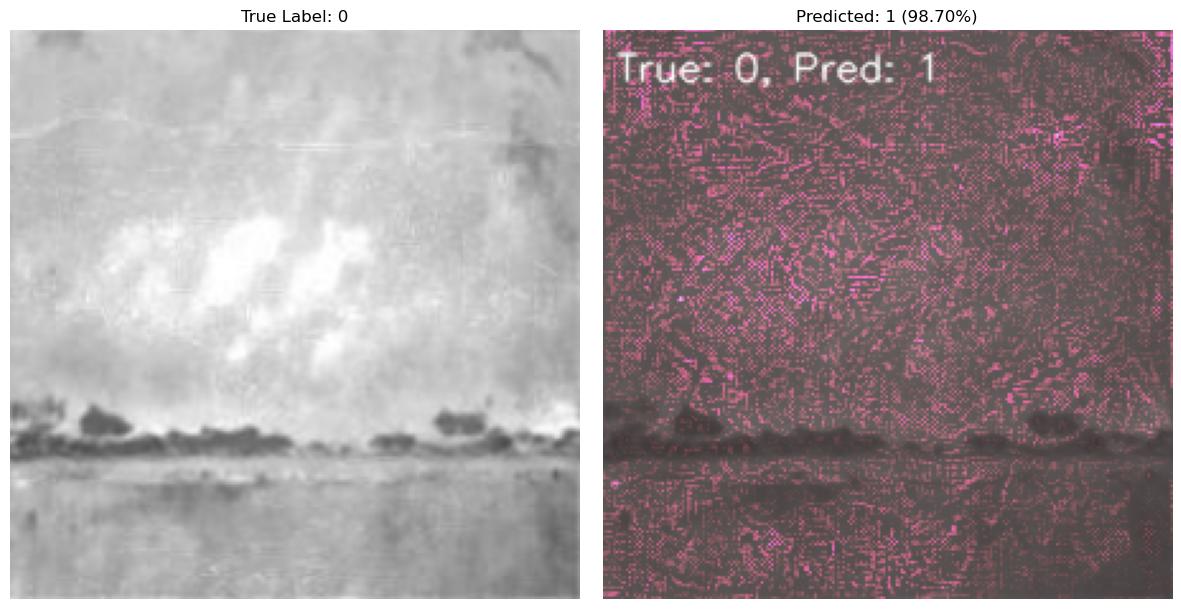

In [203]:
# Example usage
image_path = "/home/oem/eliza/DL/project/data/merged-frequencies/LowFake4.jpg"
apply_integrated_gradients_on_image(model, image_path, device='cuda', true_label=0)